# Final

You have several thousand Twitter files loaded into '/user/ivy2/Tweets/'. This is live collection, so depending on when you complete the analysis, the results might be slightly different.  Once you combine the files, there will be over 60M records, most of these records are related to either “Chicago” or “University”, but only a small fraction of these would be directly related to the University of Chicago.
 

Your objective is to identify the profiles of Twitterers, who are tweeting about University of Chicago and compare them to the profiles of Twitterers who are tweeting about other universities.  You want to make actionable business recommendations to help University improve the social media outreach programs.

In [1]:
import time
import os
import sh
import shutil
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *
from itertools import islice

import pandas as pd
import re
import json
from itertools import combinations, takewhile
import collections

from simhash import Simhash, SimhashIndex

## Loading raw data from HDFS

In [2]:
#!ls -l '/home/ivy2/Tweets/'
!hdfs dfs -ls /user/ivy2/Tweets/
#!ls -l '/project/msca/kadochnikov/Tweets'

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 13728 items
-rw-r--r--   3 ivy2 ivy2   55220293 2017-06-22 10:15 /user/ivy2/Tweets/tweets201706221015.json
-rw-r--r--   3 ivy2 ivy2   52384528 2017-06-22 11:15 /user/ivy2/Tweets/tweets201706221115.json
-rw-r--r--   3 ivy2 ivy2   56190692 2017-06-22 12:15 /user/ivy2/Tweets/tweets201706221215.json
-rw-r--r--   3 ivy2 ivy2   56992695 2017-06-22 13:15 /user/ivy2/Tweets/tweets201706221315.json
-rw-r--r--   3 ivy2 ivy2   54702790 2017-06-22 14:15 /user/ivy2/Tweets/tweets201706221415.json
-rw-r--r--   3 ivy2 ivy2   66415029 2017-06-22 15:15 /user/ivy2/Tweets/tweets201706221515.json
-rw-r--r--   3 ivy2 ivy2   63298555 2017-06-22 16:15 /user/ivy2/Tweets/tweets201706221615.json
-rw-r--r--   3 ivy2 ivy2   55417269 2017-06-22 17:15 /user/ivy2/Tweets/tweets201706221715.json
-rw-r--r--   3 ivy2 ivy2   54057246 2017-06-22 18:15 /user/ivy2/Tweets/tweets201706221815.json
-rw-r--r--   3 ivy2 ivy

-rw-r--r--   3 ivy2 ivy2   48728770 2017-07-22 17:15 /user/ivy2/Tweets/tweets201707221715.json
-rw-r--r--   3 ivy2 ivy2   53096440 2017-07-22 18:15 /user/ivy2/Tweets/tweets201707221815.json
-rw-r--r--   3 ivy2 ivy2   47431684 2017-07-22 19:15 /user/ivy2/Tweets/tweets201707221915.json
-rw-r--r--   3 ivy2 ivy2   47861220 2017-07-22 20:15 /user/ivy2/Tweets/tweets201707222015.json
-rw-r--r--   3 ivy2 ivy2   45329391 2017-07-22 21:15 /user/ivy2/Tweets/tweets201707222115.json
-rw-r--r--   3 ivy2 ivy2   44533714 2017-07-22 22:15 /user/ivy2/Tweets/tweets201707222215.json
-rw-r--r--   3 ivy2 ivy2   37604179 2017-07-22 23:15 /user/ivy2/Tweets/tweets201707222315.json
-rw-r--r--   3 ivy2 ivy2   32964615 2017-07-23 00:15 /user/ivy2/Tweets/tweets201707230015.json
-rw-r--r--   3 ivy2 ivy2   30972775 2017-07-23 01:15 /user/ivy2/Tweets/tweets201707230115.json
-rw-r--r--   3 ivy2 ivy2   24723055 2017-07-23 02:15 /user/ivy2/Tweets/tweets201707230215.json
-rw-r--r--   3 ivy2 ivy2   20709006 2017-07-23 03:

-rw-r--r--   3 ivy2 ivy2   73586230 2017-09-25 17:15 /user/ivy2/Tweets/tweets201709251715.json
-rw-r--r--   3 ivy2 ivy2   78051033 2017-09-25 18:15 /user/ivy2/Tweets/tweets201709251815.json
-rw-r--r--   3 ivy2 ivy2   70040558 2017-09-25 19:15 /user/ivy2/Tweets/tweets201709251915.json
-rw-r--r--   3 ivy2 ivy2   68567534 2017-09-25 20:15 /user/ivy2/Tweets/tweets201709252015.json
-rw-r--r--   3 ivy2 ivy2   73215943 2017-09-25 21:15 /user/ivy2/Tweets/tweets201709252115.json
-rw-r--r--   3 ivy2 ivy2   74980124 2017-09-25 22:15 /user/ivy2/Tweets/tweets201709252215.json
-rw-r--r--   3 ivy2 ivy2   68848295 2017-09-25 23:15 /user/ivy2/Tweets/tweets201709252315.json
-rw-r--r--   3 ivy2 ivy2   56438405 2017-09-26 00:15 /user/ivy2/Tweets/tweets201709260015.json
-rw-r--r--   3 ivy2 ivy2   47088448 2017-09-26 01:15 /user/ivy2/Tweets/tweets201709260115.json
-rw-r--r--   3 ivy2 ivy2   43527388 2017-09-26 02:15 /user/ivy2/Tweets/tweets201709260215.json
-rw-r--r--   3 ivy2 ivy2   38023783 2017-09-26 03:

-rw-r--r--   3 ivy2 ivy2   45856736 2017-12-13 05:15 /user/ivy2/Tweets/tweets201712130515.json
-rw-r--r--   3 ivy2 ivy2   63571763 2017-12-13 06:15 /user/ivy2/Tweets/tweets201712130615.json
-rw-r--r--   3 ivy2 ivy2   83101513 2017-12-13 07:15 /user/ivy2/Tweets/tweets201712130715.json
-rw-r--r--   3 ivy2 ivy2  116374344 2017-12-13 08:15 /user/ivy2/Tweets/tweets201712130815.json
-rw-r--r--   3 ivy2 ivy2  130263509 2017-12-13 09:15 /user/ivy2/Tweets/tweets201712130915.json
-rw-r--r--   3 ivy2 ivy2  150943178 2017-12-13 10:15 /user/ivy2/Tweets/tweets201712131015.json
-rw-r--r--   3 ivy2 ivy2  156499103 2017-12-13 11:15 /user/ivy2/Tweets/tweets201712131115.json
-rw-r--r--   3 ivy2 ivy2  161302831 2017-12-13 12:15 /user/ivy2/Tweets/tweets201712131215.json
-rw-r--r--   3 ivy2 ivy2  155921947 2017-12-13 13:15 /user/ivy2/Tweets/tweets201712131315.json
-rw-r--r--   3 ivy2 ivy2  146186274 2017-12-13 14:15 /user/ivy2/Tweets/tweets201712131415.json
-rw-r--r--   3 ivy2 ivy2  140097139 2017-12-13 15:

-rw-r--r--   3 ivy2 ivy2   87661340 2018-05-11 10:15 /user/ivy2/Tweets/tweets201805111015.json
-rw-r--r--   3 ivy2 ivy2   98831930 2018-05-11 11:15 /user/ivy2/Tweets/tweets201805111115.json
-rw-r--r--   3 ivy2 ivy2  108251111 2018-05-11 12:15 /user/ivy2/Tweets/tweets201805111215.json
-rw-r--r--   3 ivy2 ivy2  118241730 2018-05-11 13:15 /user/ivy2/Tweets/tweets201805111315.json
-rw-r--r--   3 ivy2 ivy2  111797369 2018-05-11 14:15 /user/ivy2/Tweets/tweets201805111415.json
-rw-r--r--   3 ivy2 ivy2  109765288 2018-05-11 15:15 /user/ivy2/Tweets/tweets201805111515.json
-rw-r--r--   3 ivy2 ivy2  107507663 2018-05-11 16:15 /user/ivy2/Tweets/tweets201805111615.json
-rw-r--r--   3 ivy2 ivy2  105778473 2018-05-11 17:15 /user/ivy2/Tweets/tweets201805111715.json
-rw-r--r--   3 ivy2 ivy2  102835453 2018-05-11 18:15 /user/ivy2/Tweets/tweets201805111815.json
-rw-r--r--   3 ivy2 ivy2   99720743 2018-05-11 19:15 /user/ivy2/Tweets/tweets201805111915.json
-rw-r--r--   3 ivy2 ivy2   96368758 2018-05-11 20:

-rw-r--r--   3 ivy2 ivy2   39865696 2018-08-24 03:15 /user/ivy2/Tweets/tweets201808240315.json
-rw-r--r--   3 ivy2 ivy2   38959535 2018-08-24 04:15 /user/ivy2/Tweets/tweets201808240415.json
-rw-r--r--   3 ivy2 ivy2   43147740 2018-08-24 05:15 /user/ivy2/Tweets/tweets201808240515.json
-rw-r--r--   3 ivy2 ivy2   48681257 2018-08-24 06:15 /user/ivy2/Tweets/tweets201808240615.json
-rw-r--r--   3 ivy2 ivy2   56643437 2018-08-24 07:15 /user/ivy2/Tweets/tweets201808240715.json
-rw-r--r--   3 ivy2 ivy2   66386241 2018-08-24 08:15 /user/ivy2/Tweets/tweets201808240815.json
-rw-r--r--   3 ivy2 ivy2   75710697 2018-08-24 09:15 /user/ivy2/Tweets/tweets201808240915.json
-rw-r--r--   3 ivy2 ivy2   80882703 2018-08-24 10:15 /user/ivy2/Tweets/tweets201808241015.json
-rw-r--r--   3 ivy2 ivy2   92242427 2018-08-24 11:15 /user/ivy2/Tweets/tweets201808241115.json
-rw-r--r--   3 ivy2 ivy2   92634265 2018-08-24 12:15 /user/ivy2/Tweets/tweets201808241215.json
-rw-r--r--   3 ivy2 ivy2   86569767 2018-08-24 13:

-rw-r--r--   3 ivy2 ivy2   25918666 2018-12-02 03:15 /user/ivy2/Tweets/tweets201812020315.json
-rw-r--r--   3 ivy2 ivy2   23315276 2018-12-02 04:15 /user/ivy2/Tweets/tweets201812020415.json
-rw-r--r--   3 ivy2 ivy2   23527823 2018-12-02 05:15 /user/ivy2/Tweets/tweets201812020515.json
-rw-r--r--   3 ivy2 ivy2   30321149 2018-12-02 06:15 /user/ivy2/Tweets/tweets201812020615.json
-rw-r--r--   3 ivy2 ivy2   36218053 2018-12-02 07:15 /user/ivy2/Tweets/tweets201812020715.json
-rw-r--r--   3 ivy2 ivy2   48196823 2018-12-02 08:15 /user/ivy2/Tweets/tweets201812020815.json
-rw-r--r--   3 ivy2 ivy2   55750025 2018-12-02 09:15 /user/ivy2/Tweets/tweets201812020915.json
-rw-r--r--   3 ivy2 ivy2   66990881 2018-12-02 10:15 /user/ivy2/Tweets/tweets201812021015.json
-rw-r--r--   3 ivy2 ivy2   69248632 2018-12-02 11:15 /user/ivy2/Tweets/tweets201812021115.json
-rw-r--r--   3 ivy2 ivy2   77120219 2018-12-02 12:15 /user/ivy2/Tweets/tweets201812021215.json
-rw-r--r--   3 ivy2 ivy2   84028696 2018-12-02 13:

-rw-r--r--   3 ivy2 ivy2   64789839 2019-01-26 13:15 /user/ivy2/Tweets/tweets201901261315.json
-rw-r--r--   3 ivy2 ivy2   62765456 2019-01-26 14:15 /user/ivy2/Tweets/tweets201901261415.json
-rw-r--r--   3 ivy2 ivy2   63789681 2019-01-26 15:15 /user/ivy2/Tweets/tweets201901261515.json
-rw-r--r--   3 ivy2 ivy2   68842873 2019-01-26 16:15 /user/ivy2/Tweets/tweets201901261615.json
-rw-r--r--   3 ivy2 ivy2   71702023 2019-01-26 17:15 /user/ivy2/Tweets/tweets201901261715.json
-rw-r--r--   3 ivy2 ivy2   72515062 2019-01-26 18:15 /user/ivy2/Tweets/tweets201901261815.json
-rw-r--r--   3 ivy2 ivy2   84235887 2019-01-26 19:15 /user/ivy2/Tweets/tweets201901261915.json
-rw-r--r--   3 ivy2 ivy2   77888715 2019-01-26 20:15 /user/ivy2/Tweets/tweets201901262015.json
-rw-r--r--   3 ivy2 ivy2   69721740 2019-01-26 21:15 /user/ivy2/Tweets/tweets201901262115.json
-rw-r--r--   3 ivy2 ivy2   61982414 2019-01-26 22:15 /user/ivy2/Tweets/tweets201901262215.json
-rw-r--r--   3 ivy2 ivy2   56860755 2019-01-26 23:

In [3]:
AllTweets = spark.read.json('hdfs:///user/ivy2/Tweets/*.json')
#AllTweets.cache()
#AllTweets.count() #144231598

In [4]:
AllTweets.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: bo

In [5]:
#All_tweets.limit(100).toPandas().head(5)
AllTweets.limit(100).toPandas().head(5)

contributors coordinates                      created_at display_text_range  \
0         None        None  Thu Jun 22 23:16:02 +0000 2017               None   
1         None        None  Thu Jun 22 23:16:02 +0000 2017            [0, 19]   
2         None        None  Thu Jun 22 23:16:02 +0000 2017               None   
3         None        None  Thu Jun 22 23:16:02 +0000 2017               None   
4         None        None  Thu Jun 22 23:16:02 +0000 2017               None   

                                            entities  \
0  ([], [(None, None, pic.twitter.com/ly3fCiX1x5,...   
1  ([], None, [], [(twitter.com/politicalkathy…, ...   
2  ([], None, [], [], [(21906952, 21906952, [3, 1...   
3  ([], None, [], [], [(111962487, 111962487, [3,...   
4  ([], None, [], [(None, None, [135, 135], )], [...   

                                   extended_entities extended_tweet  \
0  ([(None, None, pic.twitter.com/ly3fCiX1x5, htt...           None   
1                                               None           None   
2                                               None           None   
3                                               None           None   
4                                               None           None   

   favorite_count  favorited filter_level          ...          retweeted  \
0               0      False          low          ...              False   
1               0      False          low          ...              False   
2               0      False          low          ...              False   
3               0      False          low          ...              False   
4               0      False          low          ...              False   

                                    retweeted_status scopes  \
0  (None, None, Wed Jun 14 18:54:49 +0000 2017, [...   None   
1                                               None   None   
2  (None, None, Thu Jun 22 21:48:00 +0000 2017, N...   None   
3  (None, None, Thu Jun 22 23:00:32 +0000 2017, N...   None   
4  (None, None, Thu Jun 22 22:33:34 +0000 2017, [...   None   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text   timestamp_ms  \
0  RT @millselle: my sister graduated from univer...  1498173362077   
1        You clean up nice!😜 https://t.co/U5mw1v3cLb  1498173362106   
2  RT @ACEPNow: Mike Wilson (University of Arkans...  1498173362586   
3  RT @MikeAScotto: Chicago Bulls and Phoenix Sun...  1498173362883   
4  RT @rgofficial_3: Family in Decatur Going to F...  1498173362917   

   truncated                                               user  \
0      False  (False, Sat Nov 30 06:35:59 +0000 2013, True, ...   
1      False  (False, Thu May 24 00:20:34 +0000 2012, True, ...   
2      False  (False, Tue May 03 14:32:20 +0000 2016, True, ...   
3      False  (False, Sat Jul 25 20:15:40 +0000 2015, True, ...   
4      False  (False, Thu Jun 13 23:11:23 +0000 2013, True, ...   

   withheld_copyright withheld_in_countries  
0                None                  None  
1                None                  None  
2                None                  None  
3                None                  None  
4                None                  None  

[5 rows x 40 columns]

In [6]:
twitter_text_df = AllTweets.select('text'
        ,'user.name', 'user.description', 'user.screen_name', 'user.location'
        , 'retweet_count', 'created_at')
twitter_text_df.cache()
#twitter_text_df.toPandas().head(5)

DataFrame[text: string, name: string, description: string, screen_name: string, location: string, retweet_count: bigint, created_at: string]

In [7]:
#University of Chicago 
chicago_filter_df = twitter_text_df.\
    where('text like "%University of Chicago%" or text like "%UChi%" or text like "%UofC%" or screen_name like "%UChi%"')
#chicago_filter_df.select('screen_name', 'location', 'text').toPandas().head(100)

In [8]:
!hadoop fs -rm -r -f 'hdfs:///user/mwhossain/final/chicago/'

chicago_filter_df.write.parquet('hdfs:///user/mwhossain/final/chicago/')

!hadoop fs -ls -R 'hdfs:///user/mwhossain/final/chicago/'

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
2019-03-23 09:29:47,641 INFO  [main] fs.TrashPolicyDefault (TrashPolicyDefault.java:moveToTrash(182)) - Moved: 'hdfs://nameservice1/user/mwhossain/final/chicago' to trash at: hdfs://nameservice1/user/mwhossain/.Trash/Current/user/mwhossain/final/chicago
Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
-rw-r--r--   3 mwhossain mwhossain          0 2019-03-23 09:33 hdfs:///user/mwhossain/final/chicago/_SUCCESS
-rw-r--r--   3 mwhossain mwhossain       4261 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00000-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3781 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00001-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4988 2019-03-23 09:30 hdfs:///user/mwhossain/final/c

-rw-r--r--   3 mwhossain mwhossain      13619 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00099-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4289 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00100-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5992 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00101-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4739 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00102-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       9006 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00103-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      14237 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00104-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       7550 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00449-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7361 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00450-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6118 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00451-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7273 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00452-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6817 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00453-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4719 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-00454-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       6352 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01001-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8047 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01002-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5626 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01003-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8477 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01004-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5180 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01005-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11030 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01006-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       7155 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01724-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       9062 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01725-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      10892 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01726-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7073 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01727-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6547 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01728-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3692 2019-03-23 09:30 hdfs:///user/mwhossain/final/chicago/part-01729-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       8796 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-02403-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8857 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-02404-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7576 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-02405-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7977 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-02406-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5867 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-02407-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5517 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-02408-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       6619 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-03205-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5622 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-03206-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       9757 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-03207-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7960 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-03208-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6432 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-03209-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8378 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-03210-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       7275 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04039-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      10080 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04040-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5526 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04041-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3436 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04042-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       9810 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04043-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5843 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04044-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       5471 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04921-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7171 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04922-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      12577 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04923-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7984 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04924-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       9039 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04925-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6390 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-04926-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      18966 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-05909-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5999 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-05910-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      14877 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-05911-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6606 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-05912-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8206 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-05913-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6389 2019-03-23 09:31 hdfs:///user/mwhossain/final/chicago/part-05914-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       8590 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-06915-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4903 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-06916-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7685 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-06917-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5503 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-06918-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3694 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-06919-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8171 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-06920-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       9162 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-07916-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7341 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-07917-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      14989 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-07918-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13716 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-07919-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7110 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-07920-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      12705 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-07921-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       6219 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-09016-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11946 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-09017-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6039 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-09018-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4691 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-09019-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8190 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-09020-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6773 2019-03-23 09:32 hdfs:///user/mwhossain/final/chicago/part-09021-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       5904 2019-03-23 09:33 hdfs:///user/mwhossain/final/chicago/part-09916-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5357 2019-03-23 09:33 hdfs:///user/mwhossain/final/chicago/part-09917-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6904 2019-03-23 09:33 hdfs:///user/mwhossain/final/chicago/part-09918-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8685 2019-03-23 09:33 hdfs:///user/mwhossain/final/chicago/part-09919-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13671 2019-03-23 09:33 hdfs:///user/mwhossain/final/chicago/part-09920-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5338 2019-03-23 09:33 hdfs:///user/mwhossain/final/chicago/part-09921-69b23ebb-dace-4f37-8147-cf2a7810dbe2-c000.snappy.

In [9]:
chicago_filter_df.count()

283268

In [10]:
#NYU
nyu_filter_df = twitter_text_df.\
    where('text like "%NYU%" or text like "%New York University%" or screen_name like "%NYU%"')
#twitter_text_df.where('name like "LongLiveDaniel"')
#nyu_filter_df.cache()
#nyu_filter_df.select('screen_name', 'location', 'text').toPandas().head(100)

In [11]:
!hadoop fs -rm -r -f 'hdfs:///user/mwhossain/final/nyu/'

nyu_filter_df.write.parquet('hdfs:///user/mwhossain/final/nyu/')

!hadoop fs -ls -R 'hdfs:///user/mwhossain/final/nyu/'

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
2019-03-23 09:34:30,258 INFO  [main] fs.TrashPolicyDefault (TrashPolicyDefault.java:moveToTrash(182)) - Moved: 'hdfs://nameservice1/user/mwhossain/final/nyu' to trash at: hdfs://nameservice1/user/mwhossain/.Trash/Current/user/mwhossain/final/nyu
Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
-rw-r--r--   3 mwhossain mwhossain          0 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/_SUCCESS
-rw-r--r--   3 mwhossain mwhossain        783 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00000-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3407 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00002-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       2935 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00003-b66c29

-rw-r--r--   3 mwhossain mwhossain       3571 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00140-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5484 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00141-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3088 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00142-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3674 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00143-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3543 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00144-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4237 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00145-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       3795 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00677-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3278 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00678-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4464 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00679-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3397 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00680-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3810 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00681-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3605 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-00682-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       5287 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-01332-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3970 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-01333-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4002 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-01334-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3286 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-01335-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4600 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-01336-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3511 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-01337-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       3783 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02094-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      16772 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02095-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4068 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02096-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3540 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02097-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5627 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02098-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3476 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02099-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       3885 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02950-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3646 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02951-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4117 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02952-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3190 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02953-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3379 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02954-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       2911 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-02955-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       3558 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-03811-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4583 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-03813-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3423 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-03814-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4594 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-03816-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4900 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-03817-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4170 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-03818-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       8743 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-04819-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4658 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-04820-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3376 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-04821-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3704 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-04822-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4332 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-04823-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3574 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-04824-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       5051 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-05909-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3882 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-05910-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3646 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-05911-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3919 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-05913-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4571 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-05914-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4048 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-05915-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       3802 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-06949-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4563 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-06950-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3484 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-06951-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5089 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-06952-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5751 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-06953-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3738 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-06954-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       3864 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-07986-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6277 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-07987-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4950 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-07988-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5041 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-07989-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7719 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-07990-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4895 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-07991-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       8276 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-09078-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3919 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-09079-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3695 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-09080-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4303 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-09081-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4915 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-09082-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3389 2019-03-23 09:34 hdfs:///user/mwhossain/final/nyu/part-09083-b66c294a-6f2f-4dd7-ba16-4daad700e3e7-c000.snappy.parquet
-rw-r--r--   3 m

In [12]:
nyu_filter_df.count()

94464

In [13]:
nyu_filter_df.cache()

DataFrame[text: string, name: string, description: string, screen_name: string, location: string, retweet_count: bigint, created_at: string]

In [14]:
#Harvard
harvard_filter_df = twitter_text_df.\
    where('text like "%Harvard%" or screen_name like "%Harvard%"')
#twitter_text_df.where('name like "LongLiveDaniel"')
#harvard_filter_df.cache()
#harvard_filter_df.select('screen_name', 'location', 'text').toPandas().head(100)

In [15]:
harvard_filter_df.count()

1711663

In [16]:
!hadoop fs -rm -r -f 'hdfs:///user/mwhossain/final/harvard/'

harvard_filter_df.write.parquet('hdfs:///user/mwhossain/final/harvard/')

!hadoop fs -ls -R 'hdfs:///user/mwhossain/final/harvard/'

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
2019-03-23 09:35:39,248 INFO  [main] fs.TrashPolicyDefault (TrashPolicyDefault.java:moveToTrash(182)) - Moved: 'hdfs://nameservice1/user/mwhossain/final/harvard' to trash at: hdfs://nameservice1/user/mwhossain/.Trash/Current/user/mwhossain/final/harvard
Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
-rw-r--r--   3 mwhossain mwhossain          0 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/_SUCCESS
-rw-r--r--   3 mwhossain mwhossain       6875 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00000-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       3840 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00001-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7434 2019-03-23 09:35 hdfs:///user/mwhossain/final/h

-rw-r--r--   3 mwhossain mwhossain      13740 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00199-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15414 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00200-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      17937 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00201-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      21343 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00202-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      21348 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00203-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      18417 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00204-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      62333 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00799-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      19614 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00800-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      18608 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00801-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      19149 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00802-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      18987 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00803-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      22230 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-00804-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      25026 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01299-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      14481 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01300-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain     101406 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01301-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      19975 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01302-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      23993 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01303-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      22196 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01304-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      13269 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01899-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15812 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01900-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      20690 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01901-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13333 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01902-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      43999 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01903-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      17470 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-01904-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      18673 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-02555-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      69920 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-02556-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15990 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-02557-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      14711 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-02558-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13829 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-02559-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      17951 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-02560-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      20174 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03159-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15694 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03160-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      23863 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03161-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11797 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03162-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13353 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03163-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15092 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03164-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      15897 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03899-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      10916 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03900-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15032 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03901-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      12333 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03902-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      18950 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03903-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      20564 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-03904-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      19548 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-04899-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15896 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-04900-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      25660 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-04901-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11976 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-04902-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       9712 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-04903-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      14211 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-04904-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain       8897 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-05736-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      12567 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-05737-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11815 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-05738-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      74188 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-05739-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      19055 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-05740-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11021 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-05741-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      11615 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-06599-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8905 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-06600-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      16263 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-06601-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13102 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-06602-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6424 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-06603-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      26507 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-06604-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      23880 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-07646-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15285 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-07647-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      37250 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-07648-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      32815 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-07649-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      55655 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-07650-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      24142 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-07651-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      34514 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-08399-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15174 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-08400-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      22382 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-08401-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      21235 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-08402-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      17013 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-08403-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      20271 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-08404-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

-rw-r--r--   3 mwhossain mwhossain      22941 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-09299-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      41352 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-09300-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      27601 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-09301-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain     124469 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-09302-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      20609 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-09303-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      20339 2019-03-23 09:35 hdfs:///user/mwhossain/final/harvard/part-09304-3e630c48-3bb5-4737-999f-d1df3f0aebef-c000.snappy.

In [17]:
#MIT
mit_filter_df = twitter_text_df.\
    where('text like "%MIT%" or screen_name like "%MIT%"')
#twitter_text_df.where('name like "LongLiveDaniel"')
#mit_filter_df.cache()
#mit_filter_df.select('screen_name', 'location', 'text').toPandas().head(100)

In [18]:
mit_filter_df.count()

605925

In [19]:
!hadoop fs -rm -r -f 'hdfs:///user/mwhossain/final/mit/'

mit_filter_df.write.parquet('hdfs:///user/mwhossain/final/mit/')

!hadoop fs -ls -R 'hdfs:///user/mwhossain/final/mit/'

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
2019-03-23 09:36:39,039 INFO  [main] fs.TrashPolicyDefault (TrashPolicyDefault.java:moveToTrash(182)) - Moved: 'hdfs://nameservice1/user/mwhossain/final/mit' to trash at: hdfs://nameservice1/user/mwhossain/.Trash/Current/user/mwhossain/final/mit
Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
-rw-r--r--   3 mwhossain mwhossain          0 2019-03-23 09:37 hdfs:///user/mwhossain/final/mit/_SUCCESS
-rw-r--r--   3 mwhossain mwhossain       5523 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00000-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4946 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00001-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       5529 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00002-a35c1f

-rw-r--r--   3 mwhossain mwhossain      10810 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00070-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8518 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00071-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7297 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00072-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6583 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00073-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7501 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00074-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7603 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00075-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       8778 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00299-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       9074 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00300-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11621 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00301-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       9974 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00302-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6850 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00303-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7414 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00304-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       6649 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00899-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      19784 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00900-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6629 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00901-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6284 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00902-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8154 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00903-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11388 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-00904-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       8919 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-01680-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11167 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-01681-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       7751 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-01682-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13391 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-01683-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      10701 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-01684-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11717 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-01685-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain      22817 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-02400-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8652 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-02401-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6380 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-02402-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      17041 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-02403-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8923 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-02404-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      17039 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-02405-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain      14195 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-03199-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11584 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-03200-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15247 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-03201-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      10451 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-03202-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      17638 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-03203-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      28223 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-03204-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain      12408 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-04099-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      16035 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-04100-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13119 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-04101-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13432 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-04102-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13719 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-04103-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11802 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-04104-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain      11534 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-05112-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15867 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-05113-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      12546 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-05114-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       4268 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-05115-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      12788 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-05116-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11808 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-05117-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain       8934 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-06099-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       6805 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-06100-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      10771 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-06101-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      21974 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-06102-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      11356 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-06103-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain       8716 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-06104-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain      18226 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-07199-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      14256 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-07200-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      19332 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-07201-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      14899 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-07202-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      16550 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-07203-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      21321 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-07204-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain      16057 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-08457-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      10516 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-08458-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13619 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-08459-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      16109 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-08460-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      13157 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-08461-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      10778 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-08462-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

-rw-r--r--   3 mwhossain mwhossain      10856 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-09835-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      14680 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-09836-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      16729 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-09837-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      15770 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-09838-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      21402 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-09839-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 mwhossain mwhossain      18970 2019-03-23 09:36 hdfs:///user/mwhossain/final/mit/part-09840-a35c1f8b-6020-416d-a65e-e6c96c5893af-c000.snappy.parquet
-rw-r--r--   3 m

In [20]:
twitter_text_df = 0
AllTweets = 0

## Loading saved data from HDFS

In [2]:
#chicago_df = spark.read.load('hdfs:///user/mwhossain/final/chicago/')
#chicago_df.count()
#nyu_df = spark.read.load('hdfs:///user/mwhossain/final/nyu/')
#nyu_df.count()
harvard_df = spark.read.load('hdfs:///user/mwhossain/final/harvard/')
#harvard_df.count()
#mit_df = spark.read.load('hdfs:///user/mwhossain/final/mit/')
#mit_df.count()

# Analysis

## Simhash

In [8]:
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    #return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]
    if len(s) < 3: width = len(s) 
    return [s[i:i + width] for i in range(len(s) - width + 1)]

In [ ]:
ny_text = nyu_df.groupby('text').agg(sum('retweet_count'),count('text'))
ny_text.orderBy('sum(retweet_count)', ascending=False).show(20)

In [4]:
import re
from collections import Counter


In [7]:
text_string = pd.DataFrame.to_string(nyu_df.select('text').toPandas()).lower()
words = re.findall(r'\w+', text_string)

In [8]:
Counter(words).most_common(50)

[('rt', 64953),
 ('new', 42879),
 ('york', 37666),
 ('university', 35407),
 ('the', 13989),
 ('htt', 10390),
 ('itscollegebabes', 10375),
 ('a', 10227),
 ('nyu', 9750),
 ('to', 7704),
 ('at', 6722),
 ('is', 6447),
 ('of', 6346),
 ('s', 5225),
 ('and', 4682),
 ('my', 4400),
 ('i', 4338),
 ('are', 4254),
 ('t', 4170),
 ('in', 4167),
 ('an', 4112),
 ('n', 3982),
 ('from', 3350),
 ('we', 3333),
 ('biggest', 3313),
 ('for', 3073),
 ('will', 2867),
 ('hard', 2832),
 ('enemies', 2803),
 ('nwsltrme', 2799),
 ('school', 2690),
 ('professor', 2496),
 ('you', 2365),
 ('https', 2341),
 ('got', 2170),
 ('this', 2070),
 ('yale', 2061),
 ('y', 2009),
 ('expel', 1999),
 ('univ', 1910),
 ('animal', 1902),
 ('on', 1879),
 ('m', 1795),
 ('offer', 1774),
 ('into', 1761),
 ('student', 1713),
 ('demand', 1671),
 ('co', 1631),
 ('both', 1610),
 ('scho', 1609)]

In [34]:
nyu_df_ = nyu_df.toPandas()
nyu_data = nyu_df_['text'].to_dict()

In [10]:
string = u"itscollegebabes"

In [ ]:
objs = [(str(k), Simhash(get_features(v))) for k, v in nyu_data.items()]
index = SimhashIndex(objs, k=20)

s = Simhash(get_features(string))
s_dups = index.get_near_dups(s)
#print (index.get_near_dups(s))

In [30]:
nyu_df_.iloc[s_dups]['text']

60569    RT @itscollegebabes: New York University 📍 htt...
25504    RT @itscollegebabes: New York University 📍 htt...
58310    RT @itscollegebabes: New York University 📍 htt...
44322    RT @itscollegebabes: New York University 📍 htt...
28347    RT @itscollegebabes: New York University 📍 htt...
33244    RT @itscollegebabes: New York University 📍 htt...
39380    RT @itscollegebabes: New York University 📍 htt...
31611    RT @itscollegebabes: New York University 📍 htt...
37845    RT @itscollegebabes: New York University 📍 htt...
36293    RT @itscollegebabes: New York University 📍 htt...
55829    RT @itscollegebabes: New York University 📍 htt...
38840    RT @itscollegebabes: New York University 📍 htt...
32096    RT @itscollegebabes: New York University 📍 htt...
38477    RT @itscollegebabes: New York University 📍 htt...
55078    RT @itscollegebabes: New York University 📍 htt...
15222    RT @itscollegebabes: New York University 📍 htt...
80825    RT @itscollegebabes: New York University 📍 htt.

In [35]:
string = u"biggest"

objs = [(str(k), Simhash(get_features(v))) for k, v in nyu_data.items()]
index = SimhashIndex(objs, k=20)

s = Simhash(get_features(string))
s_dups_2 = index.get_near_dups(s)
#print (index.get_near_dups(s))
nyu_df_.iloc[s_dups_2]['text']

Big bucket found. key:5:0, len:7869
Big bucket found. key:6:1, len:6946
Big bucket found. key:0:2, len:7994
Big bucket found. key:4:3, len:8480
Big bucket found. key:6:4, len:2238
Big bucket found. key:5:5, len:10571
Big bucket found. key:5:6, len:4115
Big bucket found. key:5:7, len:4702
Big bucket found. key:3:8, len:11836
Big bucket found. key:7:9, len:4372
Big bucket found. key:2:a, len:5782
Big bucket found. key:1:b, len:22435
Big bucket found. key:2:c, len:9226
Big bucket found. key:1:d, len:14700
Big bucket found. key:6:e, len:4626
Big bucket found. key:6:f, len:4836
Big bucket found. key:5:10, len:12064
Big bucket found. key:2:11, len:8884
Big bucket found. key:6:12, len:7332
Big bucket found. key:6:13, len:13888
Big bucket found. key:8:14, len:5057


81067    @HRC It's not just Chicago Mr President https:...
38893    @NYUte25 Player that doesn't meet academic sta...
54090    When woo runs amok.... I guess this is what ha...
65202    NYU ppl, join Climate Divest!! If we don’t mak...
86622    Good luck 🍀 to imnot_katie as she travels to @...
68703    RT @j_a_tucker: Today at 5 PM! Join us via liv...
36689    @Nuqat And a lot of universities are taking no...
48497    @kanyewest I’m humbled by your honesty, don’t ...
81095    Join us, @SMUAdmission, @GWAdmissions, @Tulane...
27433    Amazing news that NYU will eliminate tuition f...
62388    what the heck? CNRS and NYU? Makes me suspect....
76279    RT @johncardillo: I spoke with Chicago PD sour...
79243    erotic chicago https://t.co/8u1HW5ZjZZ \n adul...
Name: text, dtype: object

In [32]:
text_string = pd.DataFrame.to_string(chicago_df.select('text').toPandas()).lower()
words = re.findall(r'\w+', text_string)
Counter(words).most_common(50)

[('rt', 183133),
 ('the', 75951),
 ('of', 68678),
 ('university', 56106),
 ('uchicago', 55659),
 ('chicago', 43700),
 ('to', 33808),
 ('a', 32531),
 ('s', 22526),
 ('i', 22425),
 ('at', 19983),
 ('in', 17614),
 ('is', 14799),
 ('this', 13097),
 ('for', 12011),
 ('and', 11487),
 ('t', 11484),
 ('dropping', 10955),
 ('chuckmodi1', 10906),
 ('n', 10601),
 ('on', 9353),
 ('we', 9128),
 ('you', 8322),
 ('from', 8267),
 ('o', 7722),
 ('news', 7352),
 ('breaking', 7173),
 ('my', 6578),
 ('new', 6352),
 ('was', 6204),
 ('students', 6188),
 ('it', 5446),
 ('nobel', 5290),
 ('prize', 5267),
 ('with', 5247),
 ('uofcalifornia', 5216),
 ('that', 5115),
 ('professor', 5097),
 ('have', 5025),
 ('an', 4889),
 ('2017', 4776),
 ('our', 4688),
 ('m', 4669),
 ('are', 4669),
 ('nobelprize', 4358),
 ('as', 4285),
 ('uchicagogsu', 4231),
 ('be', 4126),
 ('by', 4126),
 ('u', 4124)]

In [46]:
#chicago_df_ = chicago_df.toPandas()
chi_data = chicago_df_['text'].to_dict()

In [49]:
string = u"dropping"

objs = [(str(k), Simhash(get_features(v))) for k, v in chi_data.items()]
index = SimhashIndex(objs, k=20)

s = Simhash(get_features(string))
uc_s_dups = index.get_near_dups(s)
#print (index.get_near_dups(s))
chicago_df_.iloc[uc_s_dups]['text']

Big bucket found. key:0:0, len:25748
Big bucket found. key:4:1, len:58133
Big bucket found. key:4:2, len:65115
Big bucket found. key:2:3, len:42472
Big bucket found. key:7:4, len:21454
Big bucket found. key:1:5, len:69795
Big bucket found. key:3:6, len:65750
Big bucket found. key:2:7, len:57742
Big bucket found. key:1:8, len:82280
Big bucket found. key:4:9, len:23246
Big bucket found. key:1:a, len:54834
Big bucket found. key:0:b, len:82107
Big bucket found. key:0:c, len:20933
Big bucket found. key:6:d, len:10352
Big bucket found. key:2:e, len:60960
Big bucket found. key:0:f, len:49448
Big bucket found. key:1:10, len:44704
Big bucket found. key:0:11, len:29491
Big bucket found. key:1:12, len:17559
Big bucket found. key:0:13, len:25822
Big bucket found. key:d:14, len:19261


243748    RT @rodrikdani: I was interviewed by the UChic...
247681    Vote for Phoenix Farms, @UChicago 's sustainab...
122160    RT @SmartUChicago: "Utopian Chicago is what mi...
251481    RT @ACLUofColorado: A professor at Colorado St...
48682     RT @nugradunion: 🎉🎉🎉 UChicago grad students ha...
155121    RT @UChicago: How Steve Lehmann of #UChicago's...
98456     RT @Quantum1Net: Practical quantum computer, s...
10968     RT @BBCNorthAmerica: The University of Chicago...
137639    RT @Quantum1Net: Practical quantum computer, s...
34822     RT @ACLUofColorado: A professor at Colorado St...
208749    RT @ChicagoMaroons: That moment you realize yo...
219519    RT @mihalyfy: Student and worker hunger is bec...
230650    RT @UChicagoSSA: Alumnus Ameya Pawar and his p...
159352    RT @Quantum1Net: Practical quantum computer, s...
195415    RT @Quantum1Net: Practical quantum computer, s...
197817    RT @Quantum1Net: Practical quantum computer, s...
198812    @PhillyD @CollegeBoard @UChica

In [5]:
text_string = pd.DataFrame.to_string(harvard_df.select('text').toPandas()).lower()
words = re.findall(r'\w+', text_string)
Counter(words).most_common(50)

[('rt', 1292280),
 ('harvard', 658714),
 ('the', 315645),
 ('was', 247645),
 ('all', 181599),
 ('a', 180407),
 ('you', 179753),
 ('hard', 172687),
 ('work', 172339),
 ('worth', 169162),
 ('ayrtonlittle', 168885),
 ('at', 167789),
 ('on', 164223),
 ('it', 158331),
 ('to', 141434),
 ('says', 141031),
 ('job', 134835),
 ('university', 134815),
 ('interviewer', 131950),
 ('scientists', 115531),
 ('alezander', 107657),
 ('s', 95534),
 ('of', 90658),
 ('in', 81620),
 ('i', 78061),
 ('is', 75848),
 ('timmythick', 68963),
 ('good', 56854),
 ('univ', 52897),
 ('evening', 47906),
 ('and', 47608),
 ('n', 44684),
 ('t', 44646),
 ('brookebarreira', 43662),
 ('uni', 42183),
 ('be', 41317),
 ('this', 41166),
 ('for', 38147),
 ('your', 38049),
 ('will', 37638),
 ('ilooklikelilbil', 34257),
 ('that', 32570),
 ('has', 32519),
 ('from', 31741),
 ('an', 29846),
 ('my', 25961),
 ('top', 23778),
 ('thank', 23667),
 ('are', 23270),
 ('amonickk', 23087)]

In [6]:
harvard_df_ = harvard_df.select('text').toPandas()
harvard_data = harvard_df_['text'].to_dict()

In [ ]:
string = u"worth"

objs = [(str(k), Simhash(get_features(v))) for k, v in harvard_data.items()]
index = SimhashIndex(objs, k=20)

s = Simhash(get_features(string))
s_dups = index.get_near_dups(s)
#print (index.get_near_dups(s))
harvard_df_.iloc[s_dups]['text']

In [43]:
text_string = pd.DataFrame.to_string(mit_df.select('text').toPandas()).lower()
words = re.findall(r'\w+', text_string)
Counter(words).most_common(50)

[('rt', 408326),
 ('mit', 203324),
 ('the', 99675),
 ('to', 87116),
 ('a', 66466),
 ('of', 50075),
 ('s', 44364),
 ('in', 43897),
 ('n', 39086),
 ('is', 35849),
 ('i', 35769),
 ('and', 31791),
 ('for', 25870),
 ('t', 25447),
 ('new', 24251),
 ('this', 23380),
 ('at', 22665),
 ('from', 21207),
 ('top', 20919),
 ('universities', 19647),
 ('are', 18624),
 ('you', 18581),
 ('spectatorindex', 18432),
 ('university', 18298),
 ('that', 18048),
 ('ai', 14879),
 ('with', 14688),
 ('on', 14607),
 ('thala', 14385),
 ('chicago', 14200),
 ('rameshlaus', 14023),
 ('an', 13485),
 ('it', 12914),
 ('we', 12711),
 ('ajith', 12256),
 ('2018', 12181),
 ('have', 11975),
 ('m', 11779),
 ('https', 11709),
 ('co', 11522),
 ('researchers', 11362),
 ('be', 11358),
 ('committed', 11318),
 ('ibm', 11289),
 ('my', 11282),
 ('can', 11116),
 ('just', 11089),
 ('how', 10343),
 ('harvard', 9475),
 ('by', 9074)]

In [3]:
mit_df_ = mit_df.toPandas()
mit_data = mit_df_['text'].to_dict()

In [6]:
string = u"spectatorindex"

objs = [(str(k), Simhash(get_features(v))) for k, v in mit_data.items()]
index = SimhashIndex(objs, k=20)

s = Simhash(get_features(string))
s_dups = index.get_near_dups(s)
#print (index.get_near_dups(s))
mit_df_.iloc[s_dups]['text']

Big bucket found. key:2:0, len:113470
Big bucket found. key:2:1, len:69788
Big bucket found. key:5:2, len:110151
Big bucket found. key:2:3, len:113701
Big bucket found. key:0:4, len:65994
Big bucket found. key:1:5, len:86388
Big bucket found. key:1:6, len:174964
Big bucket found. key:6:7, len:86891
Big bucket found. key:6:8, len:56738
Big bucket found. key:0:9, len:136279
Big bucket found. key:0:a, len:99086
Big bucket found. key:7:b, len:53860
Big bucket found. key:3:c, len:67822
Big bucket found. key:1:d, len:96823
Big bucket found. key:6:e, len:82796
Big bucket found. key:4:f, len:90752
Big bucket found. key:6:10, len:32526
Big bucket found. key:6:11, len:76170
Big bucket found. key:4:12, len:89993
Big bucket found. key:6:13, len:111967
Big bucket found. key:4:14, len:58506


255121    RT @spectatorindex: Top universities, 2018-19....
230549    RT @spectatorindex: Top universities, 2018-19....
86263     RT @spectatorindex: Top universities, 2018-19....
447076    RT @spectatorindex: Top universities, 2018-19....
56391     RT @WWEPPorn: Enjoy some Stephanie McMahon rac...
493732    RT @IBMResearch: New Dean of @MITEngineering S...
144650    RT @spectatorindex: Top universities, 2018-19....
286163    RT @CamilleStein: Blues Bar - Chicago’s South ...
219170    RT @spectatorindex: Top universities, 2018-19....
86218     RT @spectatorindex: Top universities, 2018-19....
274867    Listening to @sstern_mit from @MIT : #Innovati...
45767     RT @spectatorindex: Top universities, 2018-19....
220392    RT @spectatorindex: Top universities, 2018-19....
80749     RT @spectatorindex: Top universities, 2018-19....
384419    RT @BCHLSmokeEaters: RING COMMITS TO MARIAN UN...
21723     RT @spectatorindex: Top universities, 2018-19....
137950    @MIT Quoting Page 78 of @Playb

## Group by Screen Name

In [8]:
nyu_df = nyu_filter_df

In [37]:
#Top tweeters
ny_df_grouped = nyu_df.groupby('screen_name', 'location').agg(sum('retweet_count'),count('text'))
ny_df_grouped.orderBy('count(text)', ascending=False).show(20)
#maybe should also do a orderBy ('sum', ascending=False)

+---------------+--------------------+------------------+-----------+
|    screen_name|            location|sum(retweet_count)|count(text)|
+---------------+--------------------+------------------+-----------+
|kinibottommintd|when I ignoreshar...|                 0|       1183|
|  AnimalsHolbox|              Belize|                 0|        987|
| honischgalerie|everybody is a hi...|                 0|        806|
|   trackingpaws|                null|                 0|        378|
|    gettalentUK|                null|                 0|        305|
| honischgalerie|everybody is a hi...|                 0|        302|
|truthsearch1957|       Maryland, USA|                 0|        289|
|truthsearch1957|Shadow-banned in ...|                 0|        240|
|  DSRecruitsPWD|       United States|                 0|        235|
|kinibottommintd|everybody is a hi...|                 0|        205|
|      BotsAlert|           Worldwide|                 0|        145|
|truthsearch1957|Wes

In [6]:
#Screennames by location
ny_df_sn_count = ny_df_grouped.groupby('location').agg(countDistinct('screen_name'))
#ny_df_sn_count.orderBy('count(DISTINCT screen_name)', ascending=False).show(20)

In [7]:
ny_df_norm = ny_df_sn_count.\
withColumn("Tw_Location",\
           when(col("location").like("%New York%"), "New York").\
           when(col("location").like("%NY%"), "New York").\
           when(col("location").like("USA"), "United States").\
           when(col("location").like("%London%"), "United Kingdom").\
           when(col("location").like("%Nigeria%"), "Nigeria").\
           when(col("location").like("%South Africa%"), "South Africa").\
           otherwise(col("location")))
ny_df_location = ny_df_norm.where(col("Tw_Location").isNotNull()).groupby('Tw_Location').agg(sum('count(DISTINCT screen_name)'))


In [11]:
ny_df_location = ny_df_norm.where(col("Tw_Location").isNotNull()).groupby('Tw_Location').agg(sum('count(DISTINCT screen_name)'))

In [ ]:
nyu_df_location.orderBy('sum(count(DISTINCT screen_name))', ascending=False).toPandas().head(10)

Text(0,0.5,'Number of Tweets')

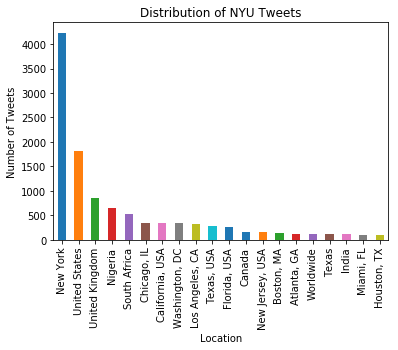

In [12]:
ny_TweetTime_plot = ny_df_location.orderBy('sum(count(DISTINCT screen_name))', ascending=False).\
    toPandas().head(20).plot(kind='bar',x='Tw_Location', y='sum(count(DISTINCT screen_name))', legend=None, title="Distribution of NYU Tweets")
ny_TweetTime_plot.set_xlabel("Location")
ny_TweetTime_plot.set_ylabel("Number of Tweets")

### Chicago

In [39]:
#Top tweeters - Chicago
chicago_df_grouped = chicago_df.groupby('screen_name', 'location').agg(sum('retweet_count'),count('text'))
chicago_df_grouped.orderBy('count(text)', ascending=False).show(20)

+---------------+--------------------+------------------+-----------+
|    screen_name|            location|sum(retweet_count)|count(text)|
+---------------+--------------------+------------------+-----------+
|       UChicago|   Chicago, Illinois|                 0|       2427|
| ChicagoMaroons|             Chicago|                 0|       1715|
|    uchicagogsu|   Chicago, IL 60637|                 0|       1360|
|LyoLouisJacques|   Chicago, Illinois|                 0|        862|
|  SmartUChicago|             Chicago|                 0|        748|
|     UChiEnergy|         Chicago, IL|                 0|        741|
|UChicagoCollege|  Hyde Park, Chicago|                 0|        604|
|   UChicagoArts|University of Chi...|                 0|        542|
| UChicagoAlumni|   Chicago, Illinois|                 0|        517|
|    UChicagoMed|         Chicago, IL|                 0|        515|
|chiftf_uchicago|         Chicago, IL|                 0|        484|
|   UChiDivinity| Sw

In [ ]:
#Screennames by location
chicago_df_sn_count = chicago_df_grouped.groupby('location').agg(countDistinct('screen_name'))
chicago_df_sn_count.orderBy('count(DISTINCT screen_name)', ascending=False).show(20)

Text(0,0.5,'Number of Tweets')

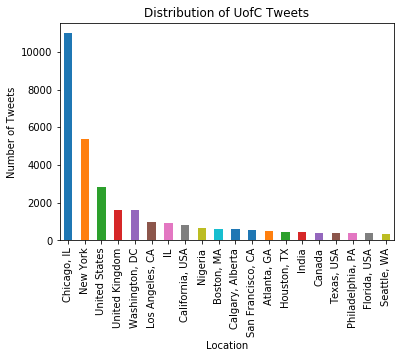

In [14]:
#Normalize locations and graph
chicago_df_norm = chicago_df_sn_count.\
withColumn("Tw_Location",\
           when(col("location").like("%New York%"), "New York").\
           when(col("location").like("%NY%"), "New York").\
           when(col("location").like("USA"), "United States").\
           when(col("location").like("%London%"), "United Kingdom").\
           when(col("location").like("%Nigeria%"), "Nigeria").\
           when(col("location").like("%South Africa%"), "South Africa").\
           when(col("location").like("%Chicago%"), "Chicago, IL").\
           when(col("location").like("%Illinois%"), "IL").\
           when(col("location").like("%,IL%"), "IL").\
           otherwise(col("location")))
chicago_df_location = chicago_df_norm.where(col("Tw_Location").isNotNull()).groupby('Tw_Location').agg(sum('count(DISTINCT screen_name)'))
#chicago_df_location.orderBy('sum(count(DISTINCT screen_name))', ascending=False).toPandas().head(10)

chicago_TweetTime_plot = chicago_df_location.orderBy('sum(count(DISTINCT screen_name))', ascending=False).\
    toPandas().head(20).plot(kind='bar',x='Tw_Location', y='sum(count(DISTINCT screen_name))', legend=None, title="Distribution of UofC Tweets")
chicago_TweetTime_plot.set_xlabel("Location")
chicago_TweetTime_plot.set_ylabel("Number of Tweets")

### Harvard

In [ ]:
#Top tweeters - Harvard
harvard_df_grouped = harvard_df.groupby('screen_name', 'location').agg(sum('retweet_count'),count('text'))
harvard_df_grouped.orderBy('count(text)', ascending=False).show(20)

In [ ]:
#Screennames by location
harvard_df_sn_count = harvard_df_grouped.groupby('location').agg(countDistinct('screen_name'))
harvard_df_sn_count.orderBy('count(DISTINCT screen_name)', ascending=False).show(20)

Text(0,0.5,'Number of Tweets')

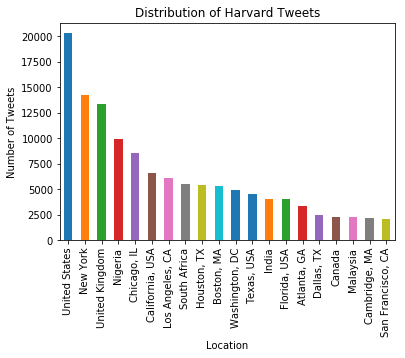

In [18]:
#Normalize locations and graph
harvard_df_norm = harvard_df_sn_count.\
withColumn("Tw_Location",\
           when(col("location").like("%New York%"), "New York").\
           when(col("location").like("%NYC%"), "New York").\
           when(col("location").like("USA"), "United States").\
           when(col("location").like("%London%"), "United Kingdom").\
           when(col("location").like("%Nigeria%"), "Nigeria").\
           when(col("location").like("%South Africa%"), "South Africa").\
           when(col("location").like("%Chicago%"), "Chicago, IL").\
           when(col("location").like("%Illinois%"), "IL").\
           when(col("location").like("%,IL%"), "IL").\
           otherwise(col("location")))
harvard_df_location = harvard_df_norm.where(col("Tw_Location").isNotNull()).groupby('Tw_Location').agg(sum('count(DISTINCT screen_name)'))
#harvard_df_location.orderBy('sum(count(DISTINCT screen_name))', ascending=False).toPandas().head(10)

harvard_TweetTime_plot = harvard_df_location.orderBy('sum(count(DISTINCT screen_name))', ascending=False).\
    toPandas().head(20).plot(kind='bar',x='Tw_Location', y='sum(count(DISTINCT screen_name))', legend=None, title="Distribution of Harvard Tweets")
harvard_TweetTime_plot.set_xlabel("Location")
harvard_TweetTime_plot.set_ylabel("Number of Tweets")

### MIT

In [42]:
#Top tweeters - MIT
mit_df_grouped = mit_df.groupby('screen_name', 'location').agg(sum('retweet_count'),count('text'))
mit_df_grouped.orderBy('count(text)', ascending=False).show(20)

+---------------+--------------------+------------------+-----------+
|    screen_name|            location|sum(retweet_count)|count(text)|
+---------------+--------------------+------------------+-----------+
|       CMasden7|                null|                 0|       6718|
|     maxgattoni|        Milan, Italy|                 0|       4085|
|duckwellsvintag|                null|                 0|       2875|
| TreasonOrTruth|         Chicago, IL|                 0|       1955|
| Chi_Red_Dragon|                 nsw|                 0|       1935|
|     Rosenchild|        New York, NY|                 0|       1879|
|      MITevents|       Cambridge, MA|                 0|       1302|
|        vrai777|     California, USA|                 0|       1301|
|     MIT_alumni|       Cambridge, MA|                 0|       1088|
|        Shyam17|    Hyderabad, India|                 0|        929|
|PetrelisMihalis|                null|                 0|        749|
|    MIT_ISTnews|   

In [ ]:
#Screennames by location
mit_df_sn_count = mit_df_grouped.groupby('location').agg(countDistinct('screen_name'))
mit_df_sn_count.orderBy('count(DISTINCT screen_name)', ascending=False).show(20)

In [ ]:
#Normalize locations and graph
mit_df_norm = mit_df_sn_count.\
withColumn("Tw_Location",\
           when(col("location").like("%New York%"), "New York").\
           when(col("location").like("%NYC%"), "New York").\
           when(col("location").like("USA"), "United States").\
           when(col("location").like("%London%"), "United Kingdom").\
           when(col("location").like("%Nigeria%"), "Nigeria").\
           when(col("location").like("%South Africa%"), "South Africa").\
           when(col("location").like("%Chicago%"), "Chicago, IL").\
           when(col("location").like("%Illinois%"), "IL").\
           when(col("location").like("%,IL%"), "IL").\
           when(col("location").like("%Boston%"), "Boston/Cambridge, MA").\
           when(col("location").like("%Cambridge%"), "Boston/Cambridge, MA").\
           otherwise(col("location")))
mit_df_location = mit_df_norm.where(col("Tw_Location").isNotNull()).groupby('Tw_Location').agg(sum('count(DISTINCT screen_name)'))
#mit_df_location.orderBy('sum(count(DISTINCT screen_name))', ascending=False).toPandas().head(10)

Text(0,0.5,'Number of Tweets')

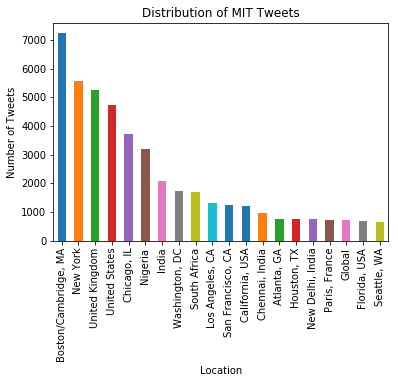

In [23]:
mit_TweetTime_plot = mit_df_location.orderBy('sum(count(DISTINCT screen_name))', ascending=False).\
    toPandas().head(20).plot(kind='bar',x='Tw_Location', y='sum(count(DISTINCT screen_name))', legend=None, title="Distribution of MIT Tweets")
mit_TweetTime_plot.set_xlabel("Location")
mit_TweetTime_plot.set_ylabel("Number of Tweets")

## Chart: Tweets over time

In [21]:
ny_df_time = nyu_df.\
withColumn("Month",\
           when(col("created_at").like("%Jan%"), 1).\
           when(col("created_at").like("%Feb%"), 2).\
           when(col("created_at").like("%Mar%"), 3).\
           when(col("created_at").like("%Apr%"), 4).\
           when(col("created_at").like("%May%"), 5).\
           when(col("created_at").like("%Jun%"), 6).\
           when(col("created_at").like("%Jul%"), 7).\
           when(col("created_at").like("%Aug%"), 8).\
           when(col("created_at").like("%Sep%"), 9).\
           when(col("created_at").like("%Oct%"), 10).\
           when(col("created_at").like("%Nov%"), 11).\
           when(col("created_at").like("%Dec%"), 12))

In [ ]:
ny_df_tweet_time_Count = ny_df_time.groupby('Month').count().orderBy('Month')
#ny_df_tweet_time_Count.toPandas().head(12)

Text(0,0.5,'Number of Tweets')

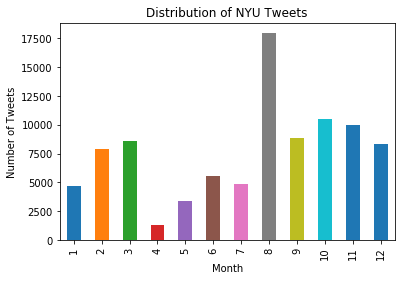

In [29]:
ny_TweetTime_plot = ny_df_tweet_time_Count.toPandas().plot(kind='bar',x='Month', y='count', legend=None, title="Distribution of NYU Tweets")
ny_TweetTime_plot.set_xlabel("Month")
ny_TweetTime_plot.set_ylabel("Number of Tweets")

In [24]:
chicago_df_dates = chicago_df.withColumn("shortDate", substring("created_at",4,3))

Text(0,0.5,'Number of Tweets')

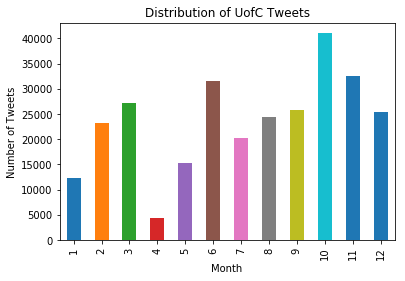

In [27]:
chicago_df_time = chicago_df.\
withColumn("Month",\
           when(col("created_at").like("%Jan%"), 1).\
           when(col("created_at").like("%Feb%"), 2).\
           when(col("created_at").like("%Mar%"), 3).\
           when(col("created_at").like("%Apr%"), 4).\
           when(col("created_at").like("%May%"), 5).\
           when(col("created_at").like("%Jun%"), 6).\
           when(col("created_at").like("%Jul%"), 7).\
           when(col("created_at").like("%Aug%"), 8).\
           when(col("created_at").like("%Sep%"), 9).\
           when(col("created_at").like("%Oct%"), 10).\
           when(col("created_at").like("%Nov%"), 11).\
           when(col("created_at").like("%Dec%"), 12))
chicago_df_tweet_time_Count = chicago_df_time.groupby('Month').count().orderBy('Month')
#chicago_df_tweet_time_Count.toPandas().head(12)
chicago_TweetTime_plot = chicago_df_tweet_time_Count.toPandas().plot(kind='bar',x='Month', y='count', legend=None, title="Distribution of UofC Tweets")
chicago_TweetTime_plot.set_xlabel("Month")
chicago_TweetTime_plot.set_ylabel("Number of Tweets")

Text(0,0.5,'Number of Tweets')

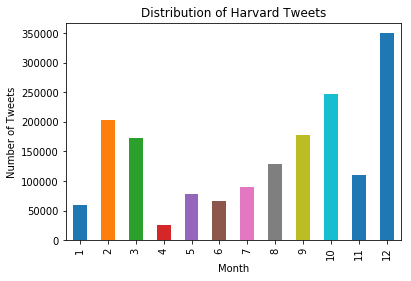

In [28]:
harvard_df_time = harvard_df.\
withColumn("Month",\
           when(col("created_at").like("%Jan%"), 1).\
           when(col("created_at").like("%Feb%"), 2).\
           when(col("created_at").like("%Mar%"), 3).\
           when(col("created_at").like("%Apr%"), 4).\
           when(col("created_at").like("%May%"), 5).\
           when(col("created_at").like("%Jun%"), 6).\
           when(col("created_at").like("%Jul%"), 7).\
           when(col("created_at").like("%Aug%"), 8).\
           when(col("created_at").like("%Sep%"), 9).\
           when(col("created_at").like("%Oct%"), 10).\
           when(col("created_at").like("%Nov%"), 11).\
           when(col("created_at").like("%Dec%"), 12))
harvard_df_tweet_time_Count = harvard_df_time.groupby('Month').count().orderBy('Month')
#harvard_df_tweet_time_Count.toPandas().head(12)
harvard_TweetTime_plot = harvard_df_tweet_time_Count.toPandas().plot(kind='bar',x='Month', y='count', legend=None, title="Distribution of Harvard Tweets")
harvard_TweetTime_plot.set_xlabel("Month")
harvard_TweetTime_plot.set_ylabel("Number of Tweets")

Text(0,0.5,'Number of Tweets')

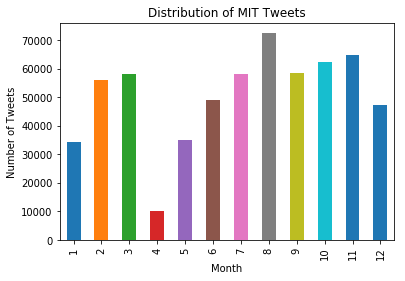

In [28]:
mit_df_time = mit_df.\
withColumn("Month",\
           when(col("created_at").like("%Jan%"), 1).\
           when(col("created_at").like("%Feb%"), 2).\
           when(col("created_at").like("%Mar%"), 3).\
           when(col("created_at").like("%Apr%"), 4).\
           when(col("created_at").like("%May%"), 5).\
           when(col("created_at").like("%Jun%"), 6).\
           when(col("created_at").like("%Jul%"), 7).\
           when(col("created_at").like("%Aug%"), 8).\
           when(col("created_at").like("%Sep%"), 9).\
           when(col("created_at").like("%Oct%"), 10).\
           when(col("created_at").like("%Nov%"), 11).\
           when(col("created_at").like("%Dec%"), 12))
mit_df_tweet_time_Count = mit_df_time.groupby('Month').count().orderBy('Month')
#mit_df_tweet_time_Count.toPandas().head(12)
mit_TweetTime_plot = mit_df_tweet_time_Count.toPandas().plot(kind='bar',x='Month', y='count', legend=None, title="Distribution of MIT Tweets")
mit_TweetTime_plot.set_xlabel("Month")
mit_TweetTime_plot.set_ylabel("Number of Tweets")